In [1]:
#imports
import os
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# change this to your dataset parent folder (where 'preprocessed_data' or 'Cannon' lives)
DATA_DIR = Path(r"C:\Users\LIKITHA\Downloads\dataset\preprocessed_data")  # <- adjust

# quick check
print("Exists:", DATA_DIR.exists())
print("Is dir:", DATA_DIR.is_dir())
list(DATA_DIR.iterdir())[:10]  # list some entries

Exists: True
Is dir: True


[WindowsPath('C:/Users/LIKITHA/Downloads/dataset/preprocessed_data/Cannon'),
 WindowsPath('C:/Users/LIKITHA/Downloads/dataset/preprocessed_data/Epson'),
 WindowsPath('C:/Users/LIKITHA/Downloads/dataset/preprocessed_data/Hp')]

In [3]:
def read_image_props(path: Path):
    """
    Read image properties using PIL.Image.
    Returns dict with:
      - file_name (relative to DATA_DIR)
      - original_format
      - width, height
      - dpi (if available)
      - color_mode (e.g. RGB, L)
      - file_size_bytes
    """
    props = {}
    try:
        with Image.open(path) as im:
            props["original_format"] = im.format
            props["width"], props["height"] = im.size
            # mode: "RGB", "L" (grayscale), "CMYK", etc.
            props["color_mode"] = im.mode
            # DPI (may be absent)
            dpi = im.info.get("dpi") or im.info.get("resolution") or None
            props["dpi"] = dpi
    except UnidentifiedImageError:
        # file not readable as image
        props["original_format"] = None
        props["width"] = None
        props["height"] = None
        props["color_mode"] = None
        props["dpi"] = None
    except Exception as e:
        props["original_format"] = None
        props["width"] = None
        props["height"] = None
        props["color_mode"] = None
        props["dpi"] = None
        props["error"] = str(e)

    props["file_name"] = str(path.name)
    props["rel_path"] = str(path.relative_to(DATA_DIR))
    props["file_size_bytes"] = path.stat().st_size if path.exists() else None
    return props

In [4]:
OUT_CSV = Path(r"C:\Users\LIKITHA\Downloads\dataset\metadata\dataset_labels.csv")  # change if needed
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# extensions to consider
EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".gif"}

rows = []
# if your dataset has top-level scanner folders (e.g., Canon, HP)
for p in tqdm(list(DATA_DIR.rglob("*"))):
    if p.is_file() and p.suffix.lower() in EXTS:
        # scanner model - assume the immediate parent directory name is the scanner model
        scanner_model = p.parent.name
        props = read_image_props(p)
        props["scanner_model"] = scanner_model
        props["full_path"] = str(p.resolve())
        rows.append(props)

meta_df = pd.DataFrame(rows)
print("Images found:", len(meta_df))
meta_df.to_csv(OUT_CSV, index=False)
meta_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2744/2744 [00:04<00:00, 683.76it/s]


Images found: 2468


,original_format,width,height,color_mode,dpi,file_name,rel_path,file_size_bytes,scanner_model,full_path
0,PNG,1080.0,1920.0,L,None,rus_internalpassport_29_000223.png,Cannon\rus_internalpassport_29_000223.png,8486,Cannon,C:\Users\LIKITHA\Downloads\dataset\preprocesse...
1,PNG,1080.0,1920.0,L,None,rus_internalpassport_29_000229.png,Cannon\rus_internalpassport_29_000229.png,8479,Cannon,C:\Users\LIKITHA\Downloads\dataset\preprocesse...
2,PNG,1080.0,1920.0,L,None,rus_internalpassport_29_000235.png,Cannon\rus_internalpassport_29_000235.png,8320,Cannon,C:\Users\LIKITHA\Downloads\dataset\preprocesse...
3,PNG,1080.0,1920.0,L,None,rus_internalpassport_29_000241.png,Cannon\rus_internalpassport_29_000241.png,8207,Cannon,C:\Users\LIKITHA\Downloads\dataset\preprocesse...
4,PNG,1080.0,1920.0,L,None,rus_internalpassport_29_000247.png,Cannon\rus_internalpassport_29_000247.png,8612,Cannon,C:\Users\LIKITHA\Downloads\dataset\preprocesse...


In [5]:
# load and inspect
meta_df = pd.read_csv(OUT_CSV)
meta_df.head()

# counts by scanner
print("Counts by scanner model:")
print(meta_df["scanner_model"].value_counts())

# formats
print("\nFormats:")
print(meta_df["original_format"].value_counts(dropna=False))

# color modes
print("\nColor modes:")
print(meta_df["color_mode"].value_counts(dropna=False))

# sizes summary
print("\nSize statistics:")
print(meta_df[["width","height","file_size_bytes"]].describe())

Counts by scanner model:
scanner_model
Epson                 1005
Cannon                 836
Hp                     468
300                    110
150                     16
EpsonV39-1               3
HP                       2
EpsonV370-1              2
EpsonV370-2              2
EpsonV39-2               2
EpsonV550                2
Canon120-1               2
Canon120-1 - Copy        2
Canon120-2               2
Canon120-2 - Copy        2
Canon220                 2
Canon220 - Copy          2
Canon9000-1              2
Canon9000-1 - Copy       2
Canon9000-2              2
Canon9000-2 - Copy       2
Name: count, dtype: int64

Formats:
original_format
JPEG    2022
TIFF     261
PNG      184
NaN        1
Name: count, dtype: int64

Color modes:
color_mode
RGB    2283
L       184
NaN       1
Name: count, dtype: int64

Size statistics:
             width       height  file_size_bytes
count  2467.000000  2467.000000     2.468000e+03
mean   1213.042967  2066.375355     2.649817e+06
std     407.

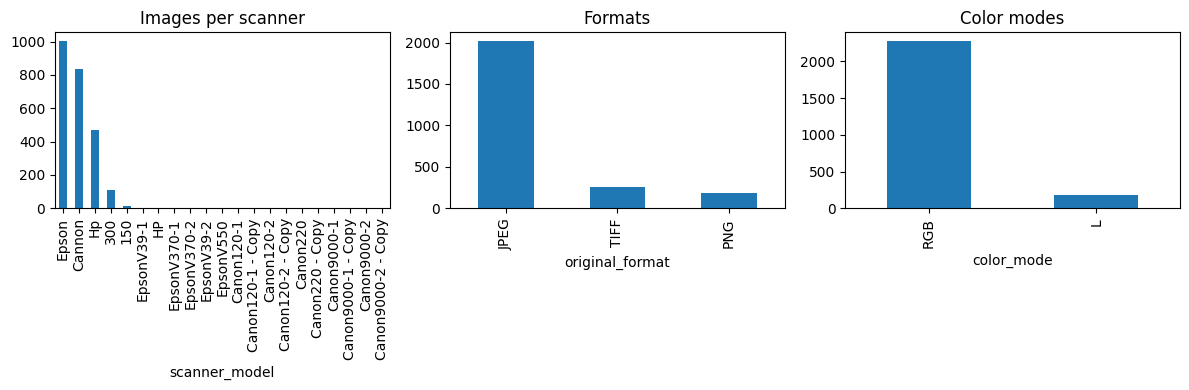

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
meta_df["scanner_model"].value_counts().plot(kind="bar")
plt.title("Images per scanner")

plt.subplot(1,3,2)
meta_df["original_format"].value_counts().plot(kind="bar")
plt.title("Formats")

plt.subplot(1,3,3)
meta_df["color_mode"].value_counts().plot(kind="bar")
plt.title("Color modes")

plt.tight_layout()
plt.show()

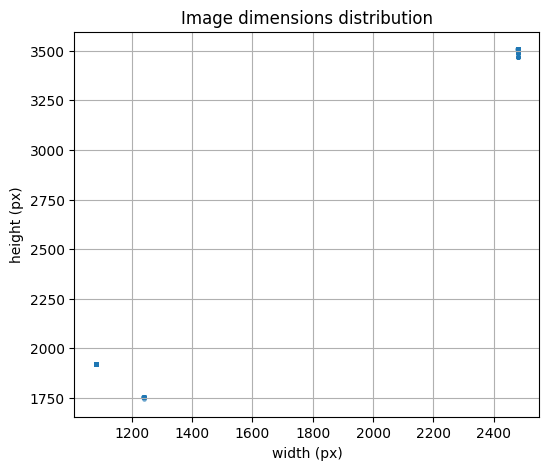

In [7]:
# scatter widths vs heights to visualize distribution
plt.figure(figsize=(6,5))
plt.scatter(meta_df["width"], meta_df["height"], s=6, alpha=0.5)
plt.xlabel("width (px)")
plt.ylabel("height (px)")
plt.title("Image dimensions distribution")
plt.grid(True)
plt.show()

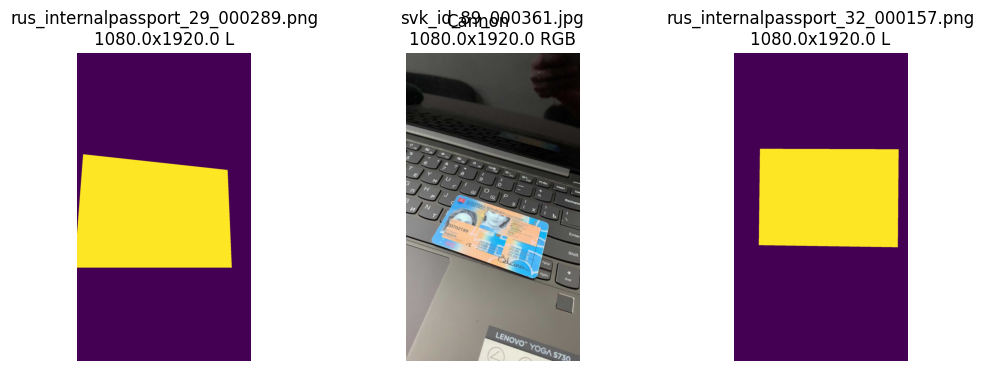

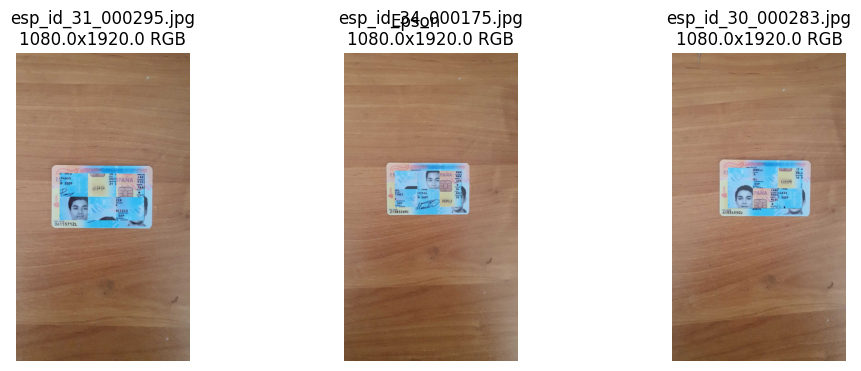

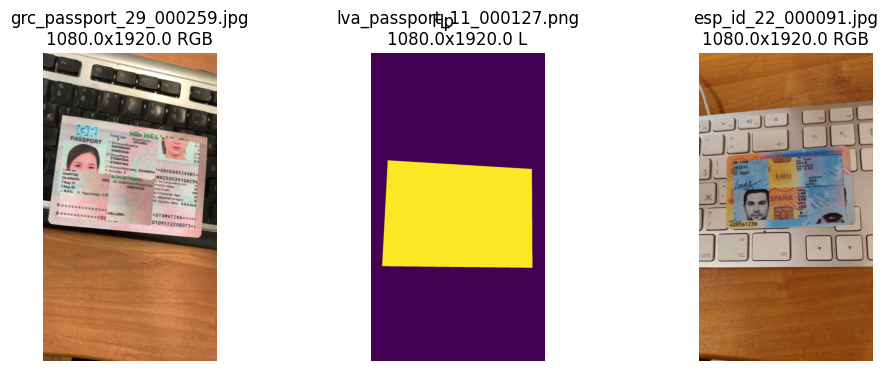

In [8]:
import matplotlib.image as mpimg

def show_samples(df, scanner_name, n=3):
    subset = df[df["scanner_model"] == scanner_name].sample(min(n, len(df)))
    plt.figure(figsize=(12,4))
    for i, (_, row) in enumerate(subset.iterrows(), 1):
        img = mpimg.imread(row["full_path"])
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{row['file_name']}\n{row['width']}x{row['height']} {row['color_mode']}")
    plt.suptitle(scanner_name)
    plt.show()

# show one example per scanner_model (adjust names shown)
for scanner in meta_df["scanner_model"].unique()[:3]:
    show_samples(meta_df, scanner, n=3)

In [9]:
bad = meta_df[meta_df["original_format"].isna() | meta_df["width"].isna()]
if len(bad):
    print("Bad/corrupt images:", len(bad))
    display(bad.head(20))
else:
    print("No corrupt images found.")

Bad/corrupt images: 1


,original_format,width,height,color_mode,dpi,file_name,rel_path,file_size_bytes,scanner_model,full_path
2315,NaN,NaN,NaN,NaN,NaN,._150.tif,Epson\EpsonV39-1\._150.tif,4096,EpsonV39-1,C:\Users\LIKITHA\Downloads\dataset\preprocesse...


In [57]:
import os
from PIL import Image
import pandas as pd

# Folder containing your images
base_dir = r"C:\Users\LIKITHA\Downloads\dataset"

corrupt_files = []

# Walk through all folders
for root, dirs, files in os.walk(base_dir):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            img = Image.open(file_path)
            img.verify()  # Check if image is readable
        except:
            corrupt_files.append(file_path)

# Delete corrupt images
for f in corrupt_files:
    print("Removing:", f)
    os.remove(f)

print("Done! Removed", len(corrupt_files), "corrupt images.")

Removing: C:\Users\LIKITHA\Downloads\dataset\metadata\week3_features.csv
Done! Removed 1 corrupt images.


In [58]:
import os
import numpy as np
from pathlib import Path
from PIL import Image, ImageFilter
from tqdm import tqdm

In [59]:
DATASET_DIR = Path(r"C:\Users\LIKITHA\Downloads\dataset\preprocessed_data")
OUTPUT_DIR = Path(r"C:\Users\LIKITHA\Downloads\dataset\week2_processed")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [60]:
IMG_SIZE = (256, 256)      # Resize target
CONVERT_TO_GRAY = False    # Set True if you want grayscale
DENOISE = False            # Set True if you want slight smoothing filter

In [61]:
processed_images = []
labels = []

for class_folder in DATASET_DIR.iterdir():
    if not class_folder.is_dir():
        continue
        
    label = class_folder.name
    print("Processing:", label)

    for img_path in tqdm(list(class_folder.glob("*.png"))):

        try:
            img = Image.open(img_path)

            # ----- 1. Resize -----
            img = img.resize(IMG_SIZE)

            # ----- 2. Convert to grayscale (optional) -----
            if CONVERT_TO_GRAY:
                img = img.convert("L")   # grayscale

            # ----- 3. Denoise (optional) -----
            if DENOISE:
                img = img.filter(ImageFilter.MedianFilter(size=3))

            # ----- 4. Normalize -----
            arr = np.array(img).astype("float32") / 255.0   # pixel scaling

            processed_images.append(arr)
            labels.append(label)

        except Exception as e:
            print("Error with:", img_path, " -> ", e)
            continue

Processing: Cannon


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:05<00:00, 33.67it/s]


Processing: Epson


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.15it/s]


Processing: Hp


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.16it/s]


In [62]:
X = np.array(processed_images)
y = np.array(labels)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (184, 256, 256)
y shape: (184,)


In [63]:
if CONVERT_TO_GRAY:
    X = np.expand_dims(X, axis=-1)

In [64]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Classes:", encoder.classes_)

Classes: ['Cannon' 'Epson' 'Hp']


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)

Train: (147, 256, 256)
Val: (37, 256, 256)


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage import filters
import cv2

In [67]:
def extract_noise_features(img):
    if img.ndim == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img
    
    img_gray = img_gray.astype(np.float32)

    # Smooth image (blur)
    smooth = cv2.GaussianBlur(img_gray, (5,5), 0)

    # Noise map
    noise_map = img_gray - smooth

    # Noise features
    noise_std = np.std(noise_map)
    noise_mean = np.mean(noise_map)
    edge_strength = np.mean(filters.sobel(img_gray))

    return noise_map, noise_std, noise_mean, edge_strength

In [68]:
def extract_fft_features(img):
    if img.ndim == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    # FFT
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    magnitude = np.log(np.abs(fshift) + 1)

    # High frequency energy
    hfreq_energy = np.mean(magnitude[0:50, 0:50])

    return magnitude, hfreq_energy

In [69]:
def extract_lbp_features(img):
    if img.ndim == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img
    
    radius = 2
    n_points = 8 * radius
    
    lbp = local_binary_pattern(img_gray, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)

    return lbp, hist

In [70]:
noise_features = []
fft_features = []
lbp_features = []
scanner_labels = []

for i in range(len(X)):
    img = (X[i] * 255).astype(np.uint8)

    # Noise
    _, noise_std, noise_mean, edge_strength = extract_noise_features(img)
    noise_features.append([noise_std, noise_mean, edge_strength])

    # FFT
    _, hf = extract_fft_features(img)
    fft_features.append([hf])

    # LBP
    _, lbp_hist = extract_lbp_features(img)
    lbp_features.append(lbp_hist)

    scanner_labels.append(y[i])

In [71]:
noise_features = np.array(noise_features)
fft_features = np.array(fft_features)
lbp_features = np.array(lbp_features)

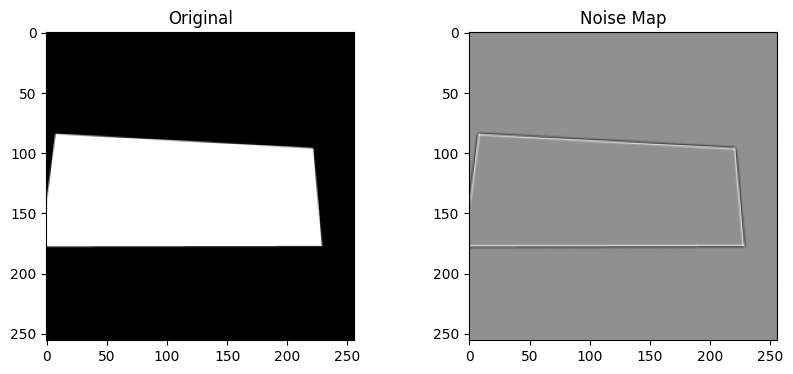

In [72]:
sample_img = (X[10] * 255).astype(np.uint8)
noise_map, *_ = extract_noise_features(sample_img)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(sample_img, cmap='gray')
plt.subplot(1,2,2); plt.title("Noise Map"); plt.imshow(noise_map, cmap='gray')
plt.show()

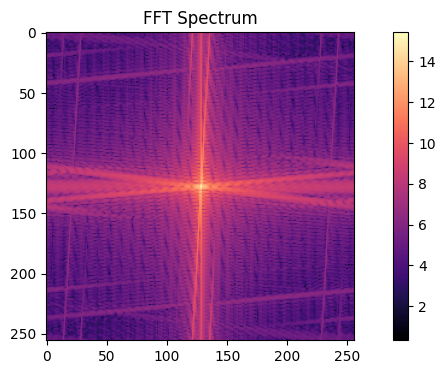

In [73]:
fft_map, _ = extract_fft_features(sample_img)

plt.figure(figsize=(10,4))
plt.imshow(fft_map, cmap='magma')
plt.title("FFT Spectrum")
plt.colorbar()
plt.show()

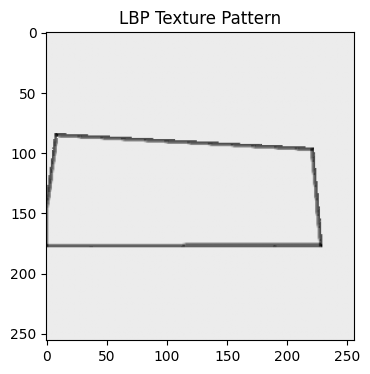

In [74]:
lbp_img, _ = extract_lbp_features(sample_img)

plt.figure(figsize=(10,4))
plt.imshow(lbp_img, cmap='gray')
plt.title("LBP Texture Pattern")
plt.show()

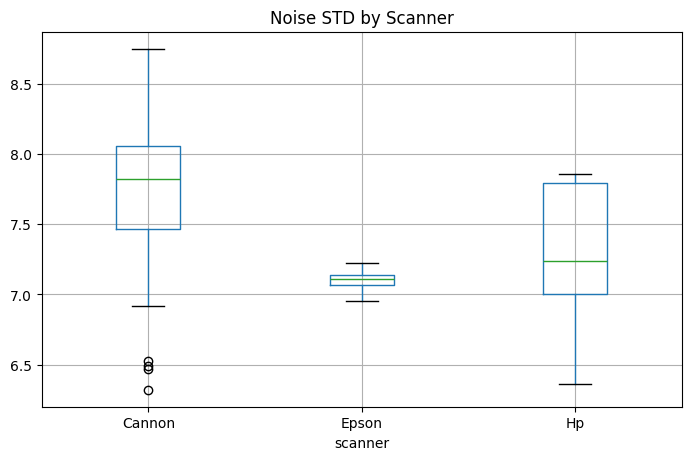

In [75]:
import pandas as pd

df = pd.DataFrame({
    "noise_std": noise_features[:,0],
    "scanner": y
})

df.boxplot(by="scanner", column="noise_std", figsize=(8,5))
plt.title("Noise STD by Scanner")
plt.suptitle("")
plt.show()

In [76]:
import numpy as np

# Combine features: noise (3), FFT (1), LBP (59 typically)
all_features = np.hstack([
    noise_features,        # shape (N, 3)
    fft_features,          # shape (N, 1)
    lbp_features           # shape (N, P)
])

In [77]:
noise_cols = ["noise_std", "noise_mean", "edge_strength"]
fft_cols = ["fft_highfreq_energy"]

lbp_cols = [f"lbp_{i}" for i in range(lbp_features.shape[1])]

column_names = noise_cols + fft_cols + lbp_cols

In [78]:
import pandas as pd

df_features = pd.DataFrame(all_features, columns=column_names)
df_features["label"] = scanner_labels  # add scanner name or ID

In [79]:
output_path = r"C:\Users\LIKITHA\Downloads\dataset\metadata\week3_features.csv"
df_features.to_csv(output_path, index=False)

print("Week-3 feature CSV saved to:", output_path)

Week-3 feature CSV saved to: C:\Users\LIKITHA\Downloads\dataset\metadata\week3_features.csv


In [80]:
import pandas as pd

# Convert feature lists to DataFrames
noise_df = pd.DataFrame(noise_features, columns=["noise_std", "noise_mean", "edge_strength"])
fft_df = pd.DataFrame(fft_features, columns=[f"fft_{i}" for i in range(len(fft_features[0]))])
lbp_df = pd.DataFrame(lbp_features)
labels_df = pd.DataFrame(scanner_labels, columns=["label"])

# Save to CSV
noise_df.to_csv("noise_features.csv", index=False)
fft_df.to_csv("fft_features.csv", index=False)
lbp_df.to_csv("lbp_features.csv", index=False)
labels_df.to_csv("scanner_labels.csv", index=False)

print("All CSV files saved successfully!")

All CSV files saved successfully!


In [81]:
import pandas as pd

noise_df = pd.read_csv("noise_features.csv")
fft_df = pd.read_csv("fft_features.csv")
lbp_df = pd.read_csv("lbp_features.csv")
labels_df = pd.read_csv("scanner_labels.csv")

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
noise_df = pd.read_csv("noise_features.csv")
fft_df = pd.read_csv("fft_features.csv")
lbp_df = pd.read_csv("lbp_features.csv")
labels_df = pd.read_csv("scanner_labels.csv")

In [84]:
print(noise_df.shape, fft_df.shape, lbp_df.shape, labels_df.shape)

(184, 3) (184, 1) (184, 18) (184, 1)


In [85]:
# Combine horizontally
features = pd.concat([noise_df, fft_df, lbp_df], axis=1)

# Labels
y = labels_df["label"]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42, stratify=y
)

In [87]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)
print("Logistic Regression Accuracy:", log_acc)

Logistic Regression Accuracy: 0.8918918918918919


In [89]:
svm_model = SVC(kernel="rbf", C=2, gamma="scale")
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)

SVM Accuracy: 0.9459459459459459


In [90]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.918918918918919


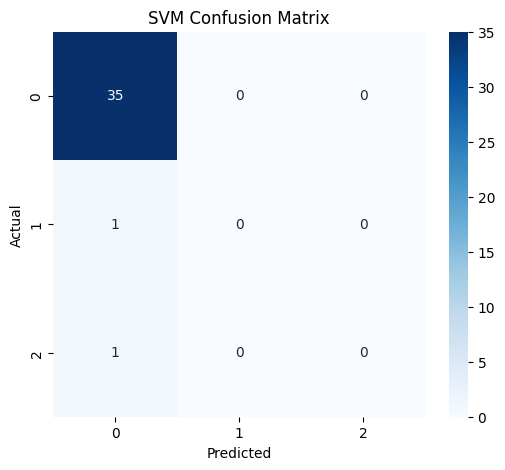

In [91]:
cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [92]:
print("\nClassification Report (SVM):")
print(classification_report(y_test, svm_pred))


Classification Report (SVM):
              precision    recall  f1-score   support

      Cannon       0.95      1.00      0.97        35
       Epson       0.00      0.00      0.00         1
          Hp       0.00      0.00      0.00         1

    accuracy                           0.95        37
   macro avg       0.32      0.33      0.32        37
weighted avg       0.89      0.95      0.92        37



C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [93]:
from sklearn.metrics import accuracy_score

# Logistic Regression
log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred) * 100
print(f"Logistic Regression Accuracy: {log_acc:.2f}%")

# SVM
svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred) * 100
print(f"SVM Accuracy: {svm_acc:.2f}%")

# Random Forest
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred) * 100
print(f"Random Forest Accuracy: {rf_acc:.2f}%")

Logistic Regression Accuracy: 89.19%
SVM Accuracy: 94.59%
Random Forest Accuracy: 91.89%


In [46]:
import os
import shutil
import numpy as np

# ----------- SET YOUR PATH HERE -----------
DATASET_PATH = r"C:\Users\LIKITHA\Downloads\dataset"  
# Inside this, you must already have folders: scannerA/, scannerB/, scannerC/

TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")

# % split for training
train_split = 0.8

# Create train/ and val/ folders
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)

# List scanner classes (folders)
classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d)) 
           and d not in ["train", "val"]]

print("Found scanner folders:", classes)

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    # Shuffle
    np.random.shuffle(images)

    # Split
    train_count = int(len(images) * train_split)
    train_files = images[:train_count]
    val_files = images[train_count:]

    # Make class folders
    os.makedirs(os.path.join(TRAIN_PATH, cls), exist_ok=True)
    os.makedirs(os.path.join(VAL_PATH, cls), exist_ok=True)

    # Move / copy files
    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(TRAIN_PATH, cls))

    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(VAL_PATH, cls))

    print(f"{cls}: {len(train_files)} → train, {len(val_files)} → val")

print("\n✅ Done! Dataset split into train/ and val/")

Found scanner folders: ['converted_images', 'metadata', 'preprocessed_data', 'raw_data', 'week2_processed']
converted_images: 0 → train, 0 → val
metadata: 0 → train, 0 → val
preprocessed_data: 0 → train, 0 → val
raw_data: 0 → train, 0 → val
week2_processed: 0 → train, 0 → val

✅ Done! Dataset split into train/ and val/


In [47]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = r"C:\Users\LIKITHA\Downloads\dataset\raw_data"
dataset_dir = r"C:\Users\LIKITHA\Downloads\dataset"

classes = os.listdir(source_dir)

train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for cls in classes:
    cls_path = os.path.join(source_dir, cls)

    images = [f for f in os.listdir(cls_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Copy TRAIN
    for img in train_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))

    # Copy VAL
    for img in val_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

print("Dataset split completed!")

Dataset split completed!


In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [49]:
train_dir = "C:/Users/LIKITHA/Downloads/dataset/train/"
val_dir = "C:/Users/LIKITHA/Downloads/dataset/val/"

In [50]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    vertical_flip=False,
    zoom_range=0.1,
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [51]:
batch_size = 16
img_size = (224, 224)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1764 images belonging to 8 classes.
Found 442 images belonging to 8 classes.


In [52]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(train_gen.num_classes, activation='softmax')
])

C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,992 (42.61 MB)

 Trainable params: 11,169,992 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
epochs = 15

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)

C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8668 - loss: 0.4026 - val_accuracy: 0.9819 - val_loss: 0.0734
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 93s 840ms/step - accuracy: 0.9728 - loss: 0.0827 - val_accuracy: 0.9932 - val_loss: 0.0317
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 790ms/step - accuracy: 0.9796 - loss: 0.0625 - val_accuracy: 0.9932 - val_loss: 0.0251
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 795ms/step - accuracy: 0.9824 - loss: 0.0593 - val_accuracy: 0.9887 - val_loss: 0.0219
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 89s 798ms/step - accuracy: 0.9847 - loss: 0.0562 - val_accuracy: 0.9910 - val_loss: 0.0228
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 788ms/step - accuracy: 0.9847 - loss: 0.0441 - val_accuracy: 0.9910 - val_loss: 0.0280
Epoch 7/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 787ms/step - accuracy: 0.9921 - loss: 0.0285 - val_accuracy: 0.9977 - val_loss: 0.0122
Epoch 8/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 791ms/step - accuracy: 0.9960 - loss: 0.0

In [56]:
loss, acc = model.evaluate(val_gen)
print("Validation Accuracy:", acc * 100, "%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - accuracy: 0.9977 - loss: 0.0108
Validation Accuracy: 99.77375268936157 %


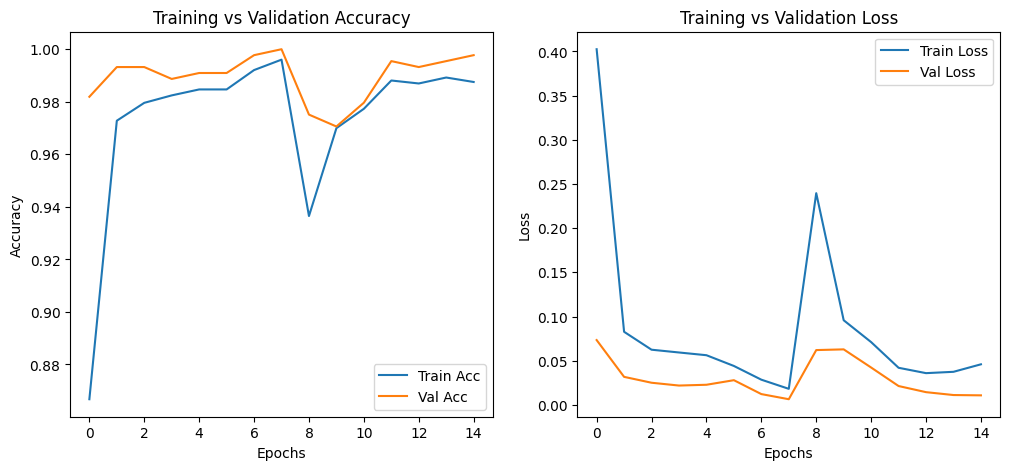

In [94]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [95]:
model.save("scanner_cnn_model.h5")

In [96]:
print("Final Train Accuracy:", history.history['accuracy'][-1] * 100)
print("Final Val Accuracy:", history.history['val_accuracy'][-1] * 100)

Final Train Accuracy: 98.75283241271973
Final Val Accuracy: 99.77375268936157


In [97]:
import numpy as np

# Get true labels
y_true = val_gen.classes

# Predict probabilities
y_pred_prob = model.predict(val_gen)

# Convert to class IDs
y_pred = np.argmax(y_pred_prob, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 376ms/step


In [101]:
from sklearn.metrics import classification_report

class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

ValueError: Number of classes, 3, does not match size of target_names, 8. Try specifying the labels parameter

In [102]:
from sklearn.metrics import classification_report
import numpy as np

# --- Step 1: true labels ---
y_true = val_gen.classes

# --- Step 2: predicted labels ---
y_pred = model.predict(val_gen)
y_pred = np.argmax(y_pred, axis=1)

# --- Step 3: class names ---
class_labels = list(val_gen.class_indices.keys())

# --- Step 4: print report ---
print(classification_report(y_true, y_pred, target_names=class_labels))

28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step


ValueError: Number of classes, 3, does not match size of target_names, 8. Try specifying the labels parameter

In [103]:
print("Classes:", val_gen.class_indices)
print("Number of classes:", val_gen.num_classes)

Classes: {'Cannon': 0, 'Epson': 1, 'Hp': 2, 'converted_images': 3, 'metadata': 4, 'preprocessed_data': 5, 'raw_data': 6, 'week2_processed': 7}
Number of classes: 8
